In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import yfinance as yf
import datetime

from valueinvesting import utils as utils

# 1. Load raw input
## Hardcoded block

In [2]:
evaluate_last_X_years = True
X=10
currency_pair = 'EUR=X'
numbers_in_currency = 'EUR'
share_name = 'FORTUM.HE'

# 1.1 Calculate Share numbers from total distributed dividend (CFS) and dividend amount

# 1.2. Raw input statement data

In [3]:
route = f"../data/input/{share_name}_data.csv"
data = pd.read_csv(route, sep=';', parse_dates=['date', 'real_date'])
# replace -, extend missing 0-s, fix datatype
data = utils.replace_format_input(data)

In [4]:
owned_shares = pd.read_csv('../data/extras/owned_stocks.csv', sep=';', parse_dates=['date'])
owned_shares = owned_shares.loc[(owned_shares['stock'] == share_name) & (owned_shares['active'] == 'yes')]

## (OPTIONAL) Time Filtering - Last 7 years daat

In [5]:
if evaluate_last_X_years:
    data = data[data['date'] > datetime.datetime.today() - datetime.timedelta(days=X*366+93)]
    data = data.reset_index(drop=True)

data.head()

,date,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,curr_assets,goodwill,...,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,shares,real_date
0,2014-12-31,1133,-473,660,523,2009,830,256,4301,170,...,0,287,816,2067,5881,10511,452,-200,888.3,2015-03-01
1,2015-03-31,1040,-433,607,295,1773,637,247,7212,197,...,0,214,824,3698,5944,11761,603,-101,888.3,2015-05-10
2,2015-06-30,794,-363,431,118,2774,612,270,9857,197,...,0,176,1560,2543,5029,9659,296,-108,888.3,2015-08-09
3,2015-09-30,661,-312,349,-658,2390,574,258,9238,168,...,0,250,836,1836,5010,8793,151,-138,888.3,2015-11-09
4,2015-12-31,964,-407,557,18,3289,822,231,9610,0,...,0,204,838,2042,4965,8973,331,-180,888.3,2016-02-29


## Calculate date when quaterly reports could be available

In [6]:
data = utils.calculate_real_date(data)

# 2. Filter out unnecesary columns

In [7]:
data = utils.filter_raw_data(data)
data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,intangible_assets,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex
35,2023-09-30,2023-11-09,897.2,122,-665,-543,186,4552,831,322,...,643,18842,0,495,1035,3726,4409,10398,429,-146
36,2023-12-31,2024-02-29,897.2,1858,-1106,752,412,4183,1286,452,...,643,18739,0,507,961,3708,4476,10300,149,-130
37,2024-03-31,2024-05-10,897.2,2015,-1167,848,473,4875,1030,405,...,619,18956,0,580,1815,4484,4039,10566,538,-110
38,2024-06-30,2024-08-12,897.2,1255,-696,559,215,4058,796,411,...,619,17796,0,456,556,2361,4829,9240,338,-108
39,2024-09-30,2024-10-28,897.2,1094,-611,483,133,4255,692,348,...,560,17729,0,420,509,2149,4843,8923,349,-133


## Pull historical average USD national currency rates and add to the dataframe

In [8]:
data['usd_nat_currency'] = utils.daily_price(
    ticker=currency_pair,
    end=data['date'],
    days_earlier=90
    )

# drop rows, when USD rates wasn't available
data = data[data['usd_nat_currency'].notna()]

data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
35,2023-09-30,2023-11-09,897.2,122,-665,-543,186,4552,831,322,...,18842,0,495,1035,3726,4409,10398,429,-146,0.918837
36,2023-12-31,2024-02-29,897.2,1858,-1106,752,412,4183,1286,452,...,18739,0,507,961,3708,4476,10300,149,-130,0.929674
37,2024-03-31,2024-05-10,897.2,2015,-1167,848,473,4875,1030,405,...,18956,0,580,1815,4484,4039,10566,538,-110,0.920544
38,2024-06-30,2024-08-12,897.2,1255,-696,559,215,4058,796,411,...,17796,0,456,556,2361,4829,9240,338,-108,0.928647
39,2024-09-30,2024-10-28,897.2,1094,-611,483,133,4255,692,348,...,17729,0,420,509,2149,4843,8923,349,-133,0.910617


## Convert USD values related to IS, BS, CFS to national currency

In [9]:
# convert columns into national currency if necessary
if numbers_in_currency == 'USD':
    data_nat_curr = utils.convert_national_currency(input_data=data, currency=data)
else:
    data_nat_curr = data.copy()
data_nat_curr.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
35,2023-09-30,2023-11-09,897.2,122,-665,-543,186,4552,831,322,...,18842,0,495,1035,3726,4409,10398,429,-146,0.918837
36,2023-12-31,2024-02-29,897.2,1858,-1106,752,412,4183,1286,452,...,18739,0,507,961,3708,4476,10300,149,-130,0.929674
37,2024-03-31,2024-05-10,897.2,2015,-1167,848,473,4875,1030,405,...,18956,0,580,1815,4484,4039,10566,538,-110,0.920544
38,2024-06-30,2024-08-12,897.2,1255,-696,559,215,4058,796,411,...,17796,0,456,556,2361,4829,9240,338,-108,0.928647
39,2024-09-30,2024-10-28,897.2,1094,-611,483,133,4255,692,348,...,17729,0,420,509,2149,4843,8923,349,-133,0.910617


# 3. Calculate input to Value Raios (eps, bv per share, fcf)
## filter out unwanted columns

In [10]:
filtered_nat_curr = utils.calculate_input_value_ratios(data_nat_curr)

## Calculate input values to value ratios

In [11]:
ratios_nat_curr = utils.ratios_input_filter(filtered_nat_curr)

## Calculate performance parameters (current ratio, ROA, ROE, margins, D/E)

In [12]:
ratios_nat_curr = utils.evaluate_performance(input=filtered_nat_curr, output=ratios_nat_curr)

# 4. Pull historical share prices and merge with sattement data

In [13]:
# pull weekly share prices and merge with the value ratios
merged_nat_curr = utils.add_share_prices_to_value_ratios(share_name, data, ratios_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,equity_ratio,debt_ratio,acc_rec_ratio,acc_pay_ratio,cash_turnover,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe
0,2015-03-02,10.251500,2014-12-31,1133.0,0.0,12.230102,888.3,0.0,0.0,2009.0,...,0.508257,0.491743,0.0,0.0,0.0,0.0,0.582524,0.461606,0.0,0.0
1,2015-03-09,10.437615,2014-12-31,1133.0,0.0,12.230102,888.3,0.0,0.0,2009.0,...,0.508257,0.491743,0.0,0.0,0.0,0.0,0.582524,0.461606,0.0,0.0
2,2015-03-16,10.120715,2014-12-31,1133.0,0.0,12.230102,888.3,0.0,0.0,2009.0,...,0.508257,0.491743,0.0,0.0,0.0,0.0,0.582524,0.461606,0.0,0.0
3,2015-03-23,9.969810,2014-12-31,1133.0,0.0,12.230102,888.3,0.0,0.0,2009.0,...,0.508257,0.491743,0.0,0.0,0.0,0.0,0.582524,0.461606,0.0,0.0
4,2015-03-30,9.129770,2014-12-31,1133.0,0.0,12.230102,888.3,0.0,0.0,2009.0,...,0.508257,0.491743,0.0,0.0,0.0,0.0,0.582524,0.461606,0.0,0.0


# Calculate price ratios (P/E, P/B, P/S, P/FCF)

In [14]:
merged_nat_curr = utils.price_ratios(merged_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,pfcf_ratio
0,2015-03-02,10.251500,2014-12-31,1133.0,0.0,12.230102,888.3,0.0,0.0,2009.0,...,0.0,0.582524,0.461606,0.0,0.0,inf,0.838219,inf,inf,inf
1,2015-03-09,10.437615,2014-12-31,1133.0,0.0,12.230102,888.3,0.0,0.0,2009.0,...,0.0,0.582524,0.461606,0.0,0.0,inf,0.853436,inf,inf,inf
2,2015-03-16,10.120715,2014-12-31,1133.0,0.0,12.230102,888.3,0.0,0.0,2009.0,...,0.0,0.582524,0.461606,0.0,0.0,inf,0.827525,inf,inf,inf
3,2015-03-23,9.969810,2014-12-31,1133.0,0.0,12.230102,888.3,0.0,0.0,2009.0,...,0.0,0.582524,0.461606,0.0,0.0,inf,0.815186,inf,inf,inf
4,2015-03-30,9.129770,2014-12-31,1133.0,0.0,12.230102,888.3,0.0,0.0,2009.0,...,0.0,0.582524,0.461606,0.0,0.0,inf,0.746500,inf,inf,inf


# Calculate Dividend yield and currency-share price correlation

In [15]:
# get daily historical USD-national currency rates
usd_nat_curr = utils.get_historical_currency_rate(currency_pair, merged_nat_curr)

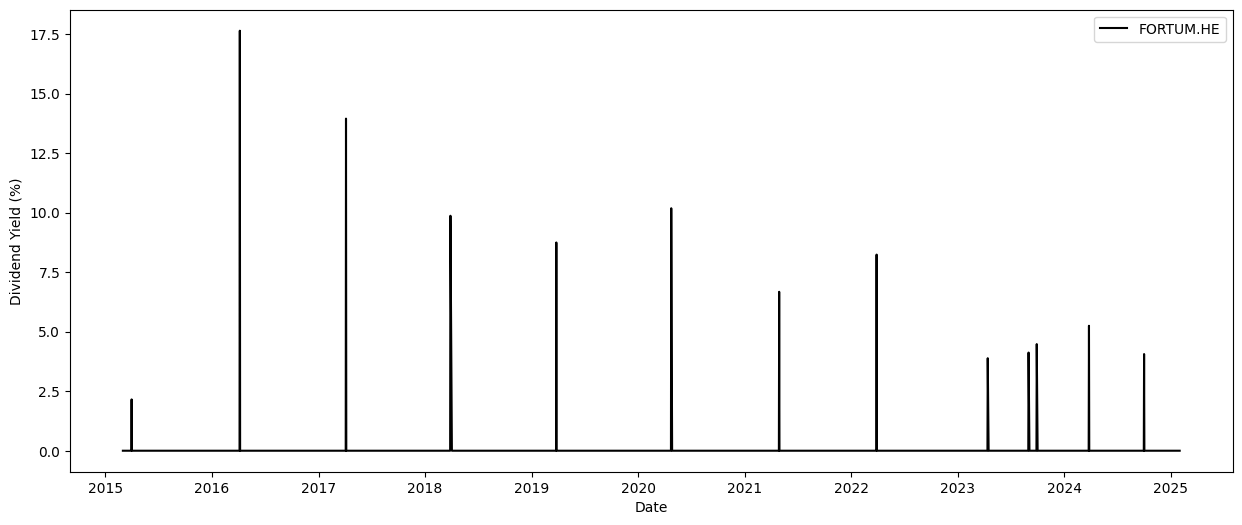

In [16]:
# get share prices and dividend yield data
ticker_all_price = utils.get_historical_share_dividend(share_name, merged_nat_curr)

currency_rate   -0.310588
share_price      1.000000
Name: share_price, dtype: float64


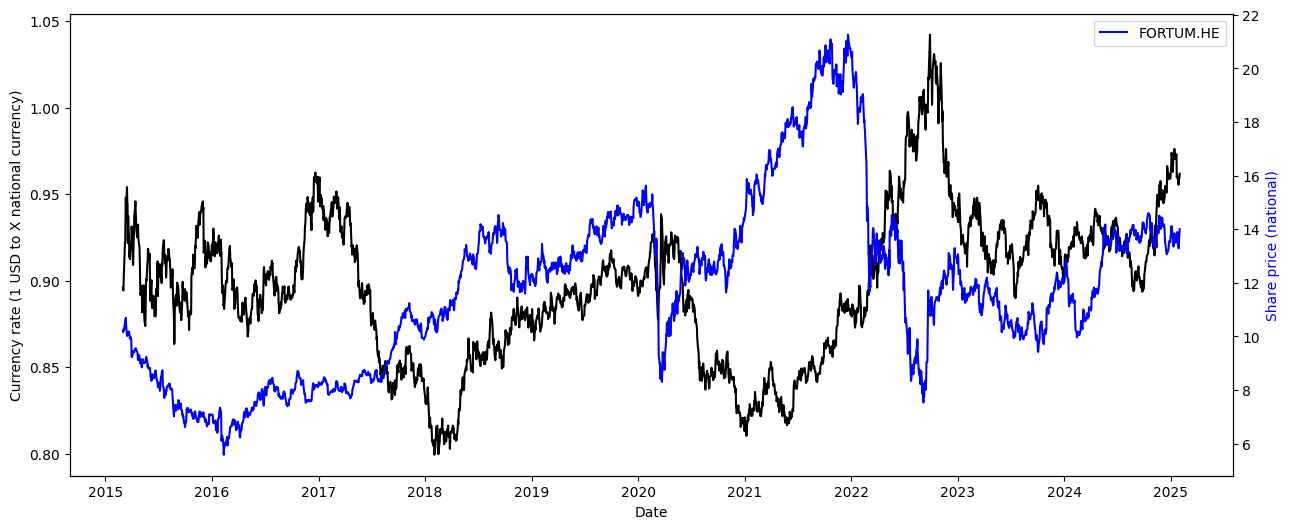

In [17]:
# Pearson's correlation coefficient between share price and USD - national currency rate
utils.get_currency_share_price_correlation(share_name, usd_nat_curr, ticker_all_price)

# Share price and value ratios

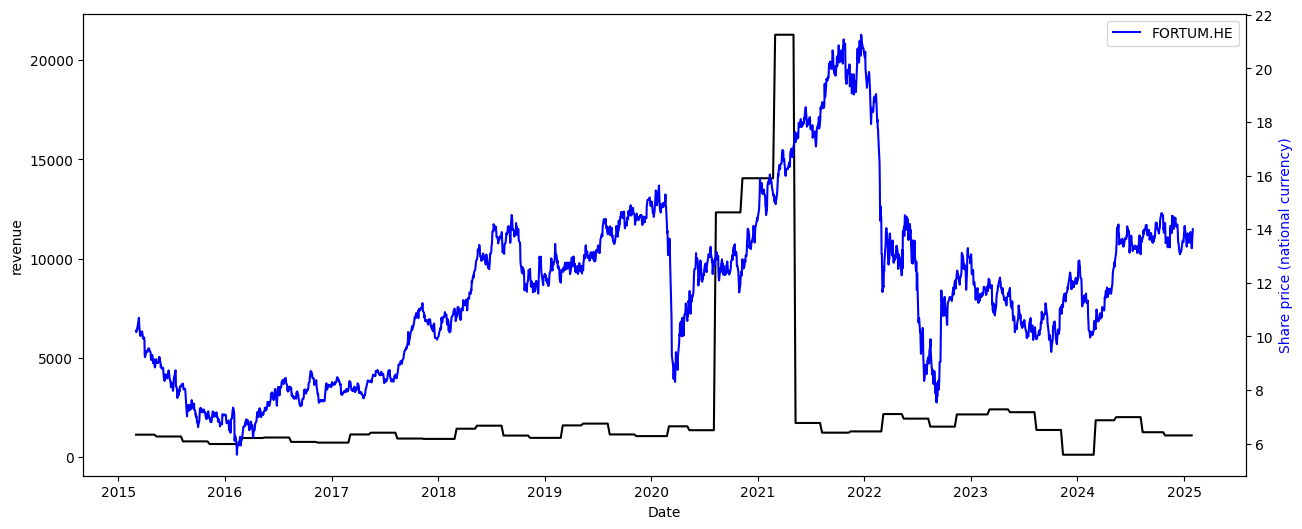

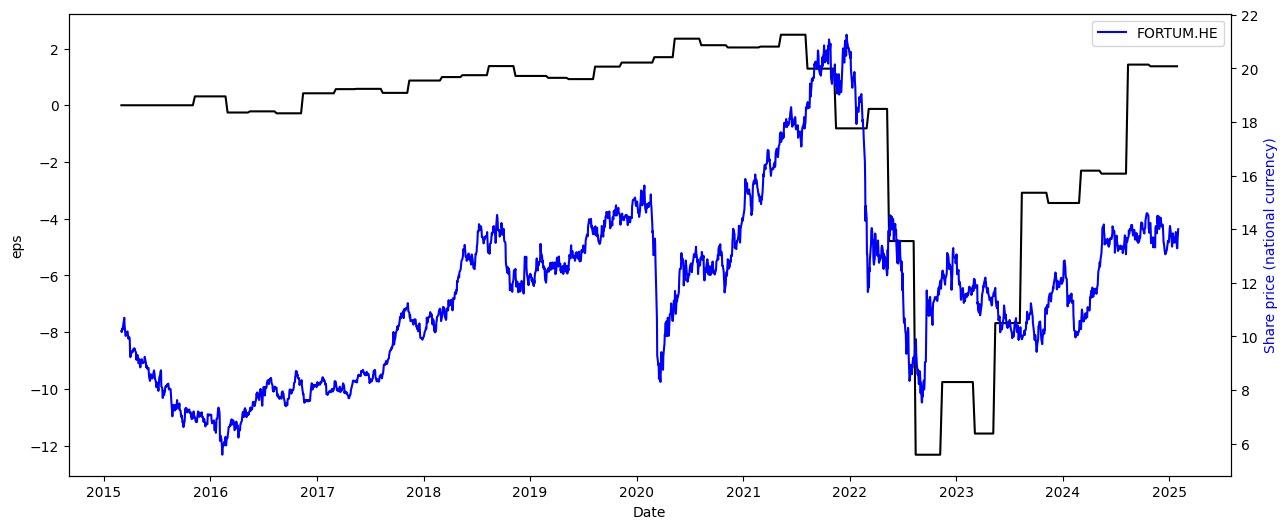

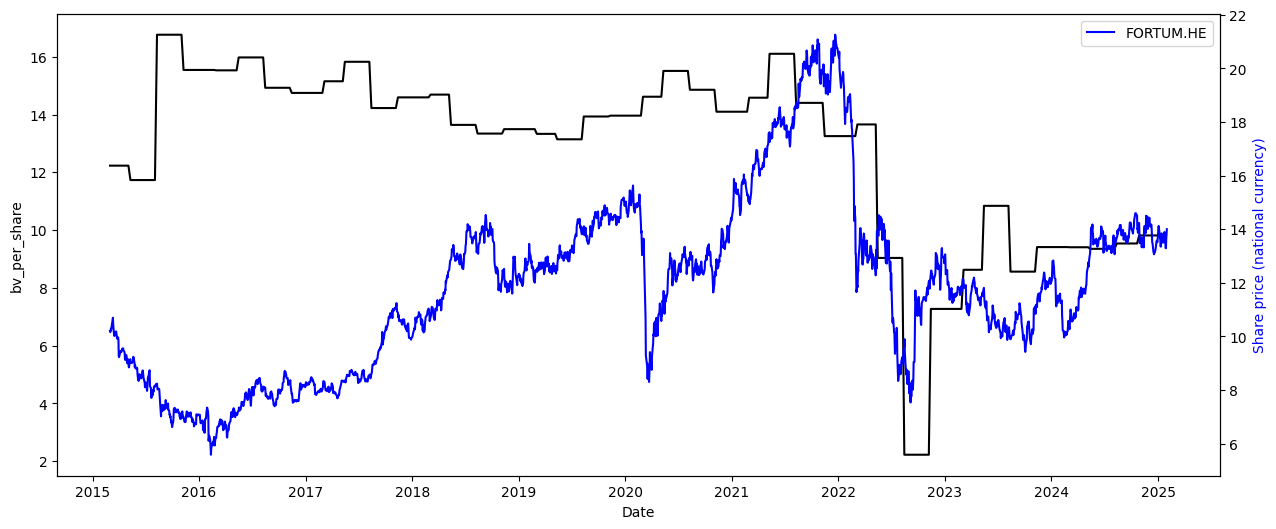

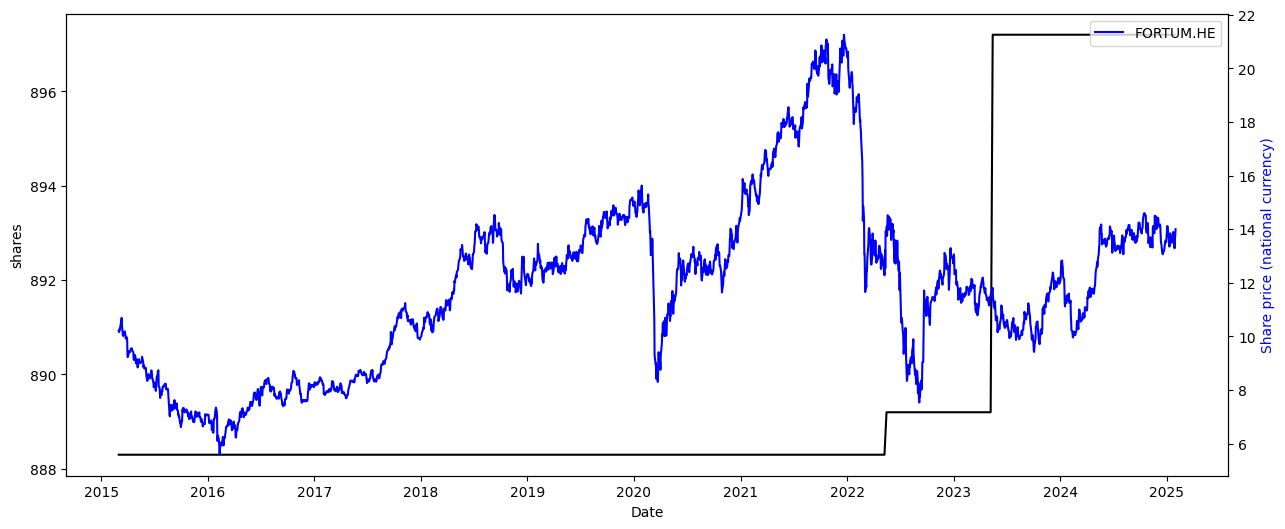

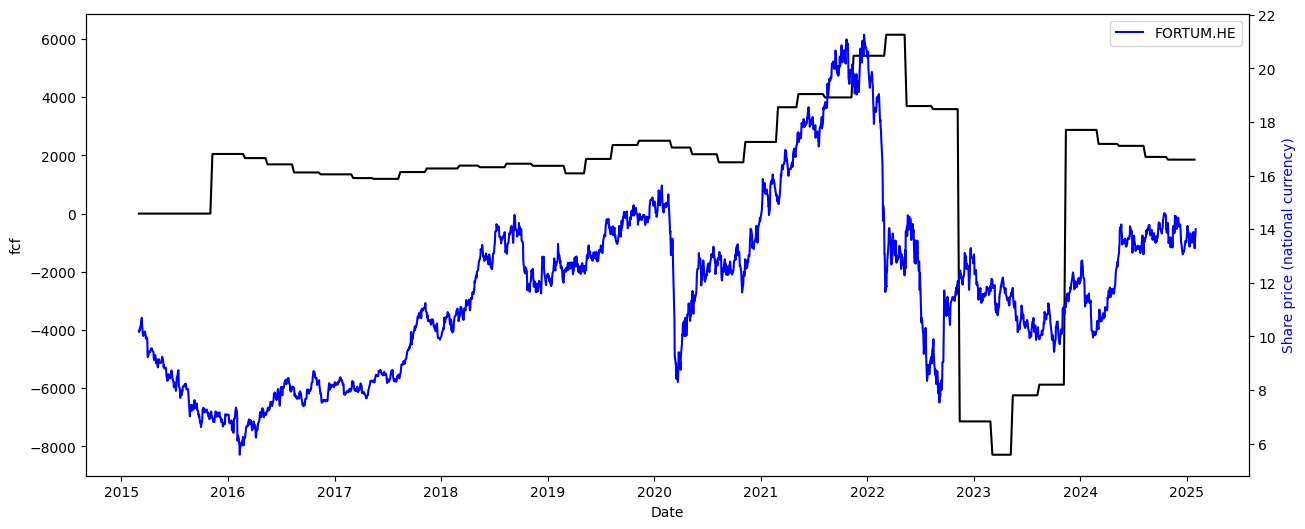

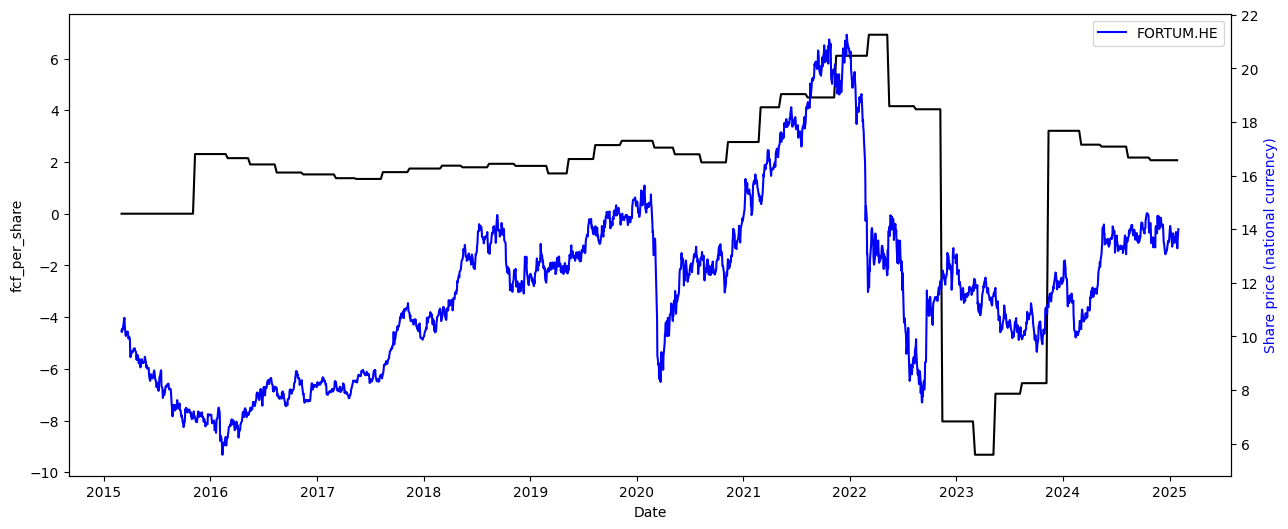

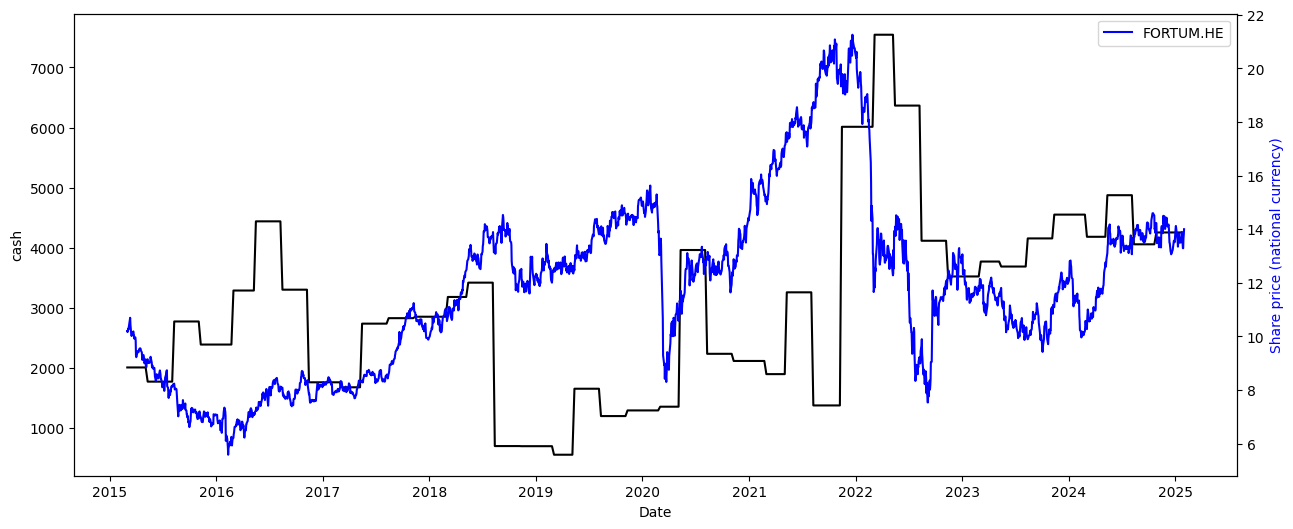

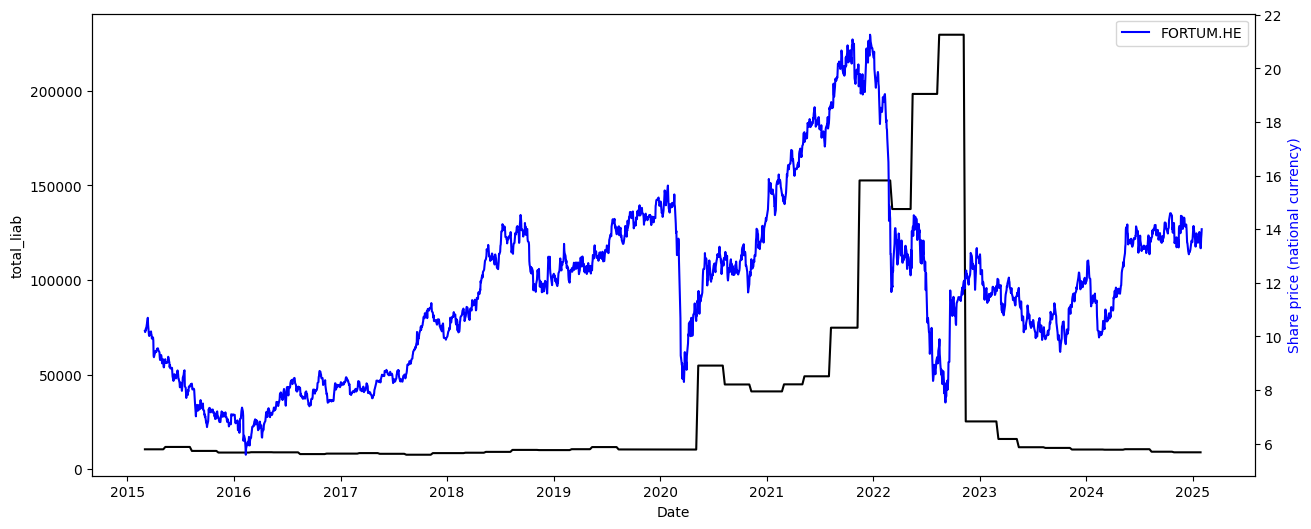

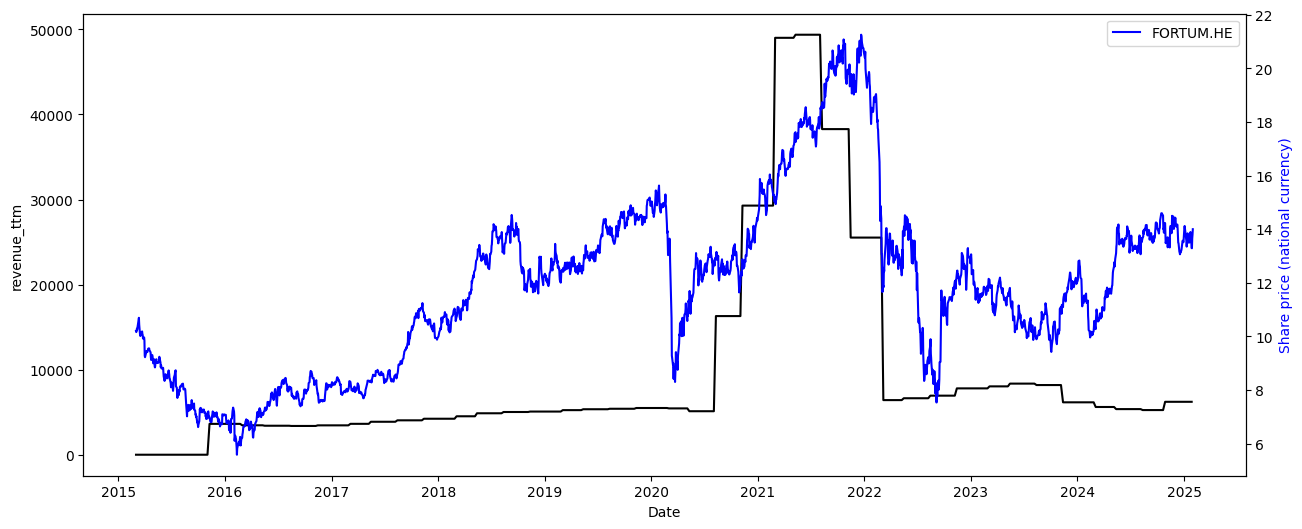

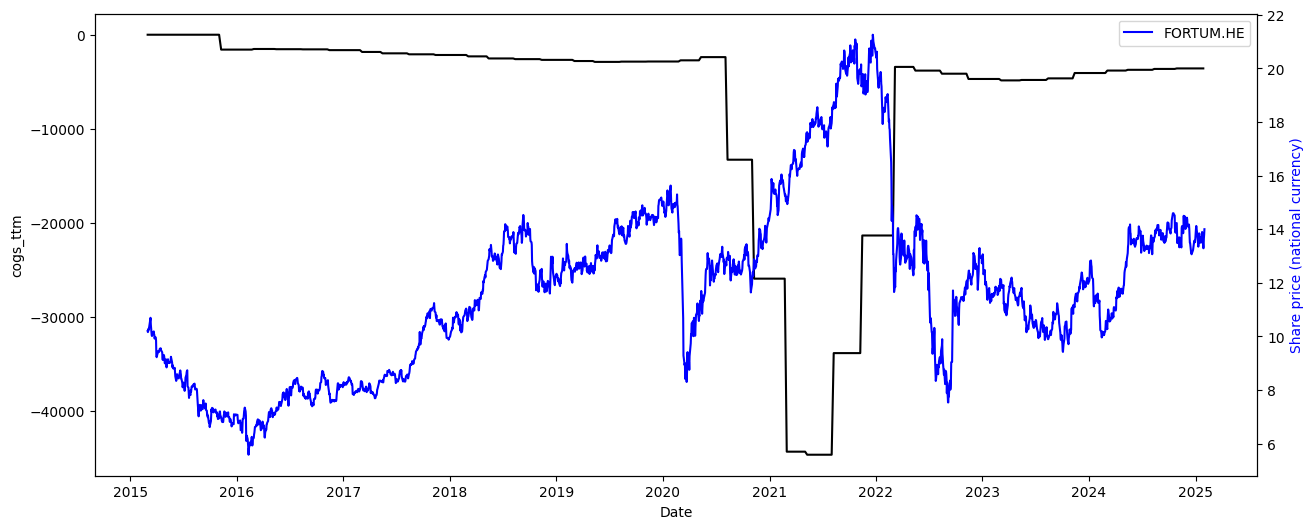

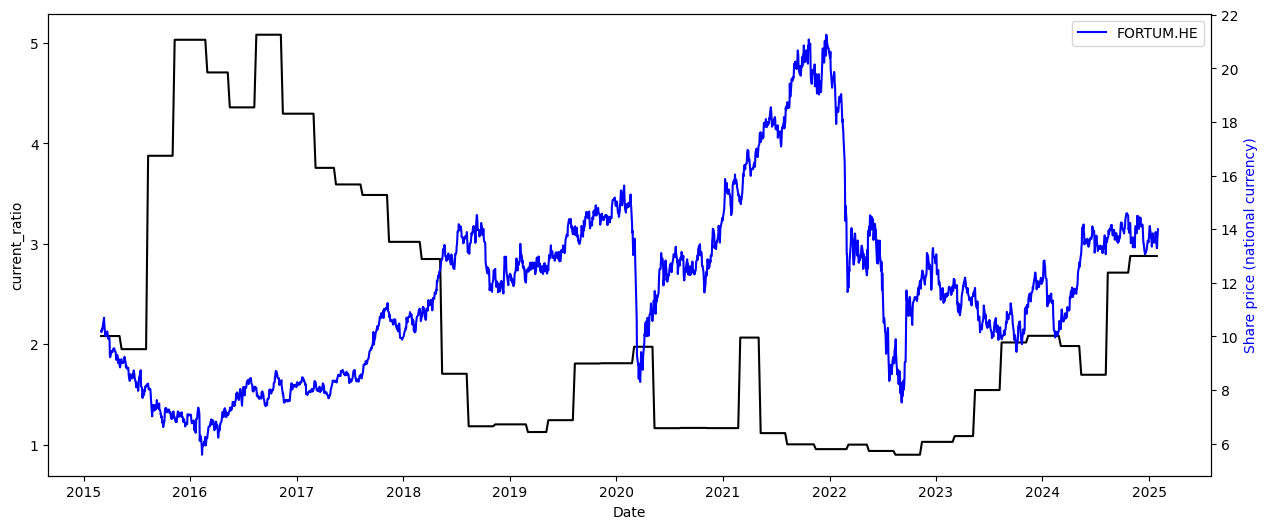

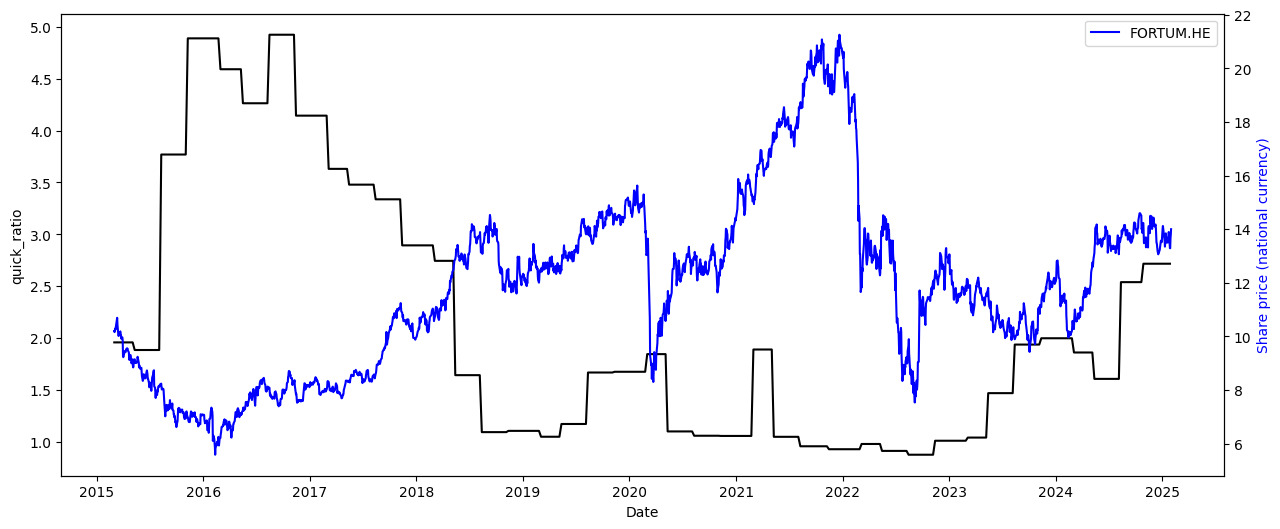

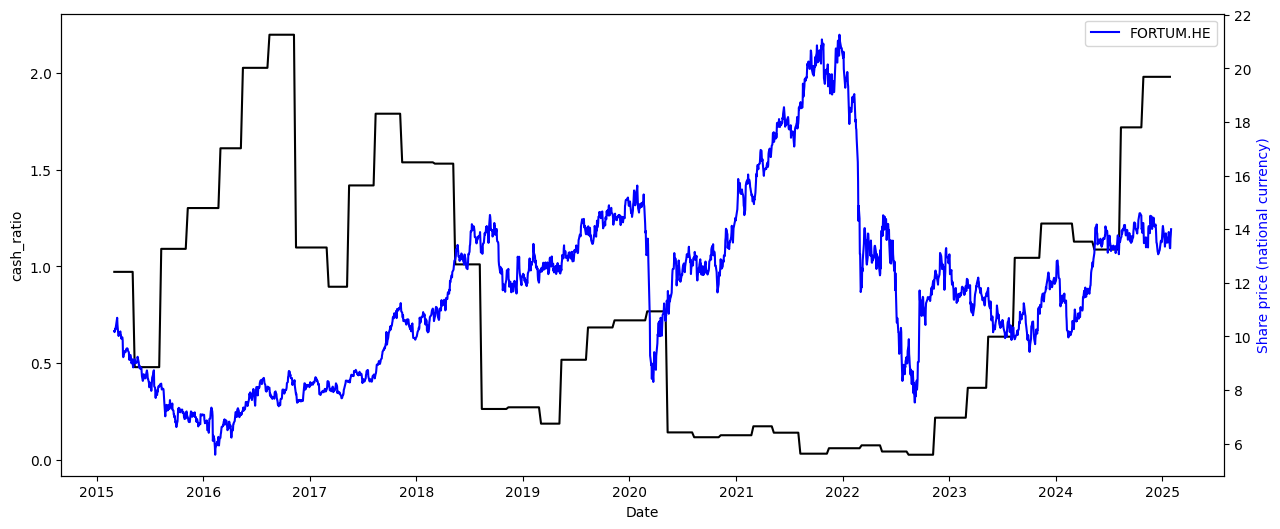

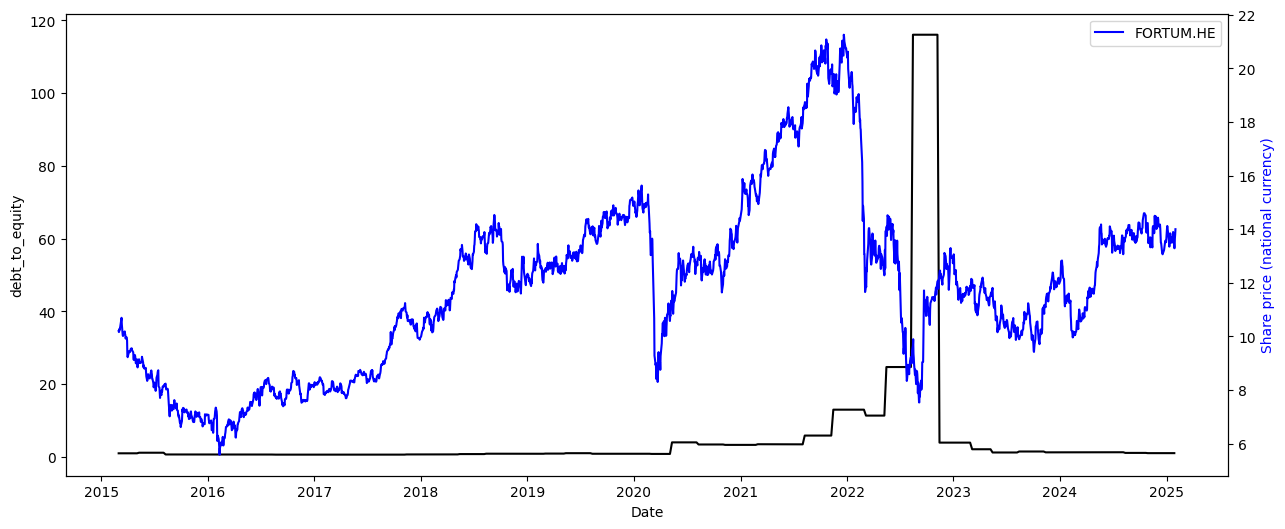

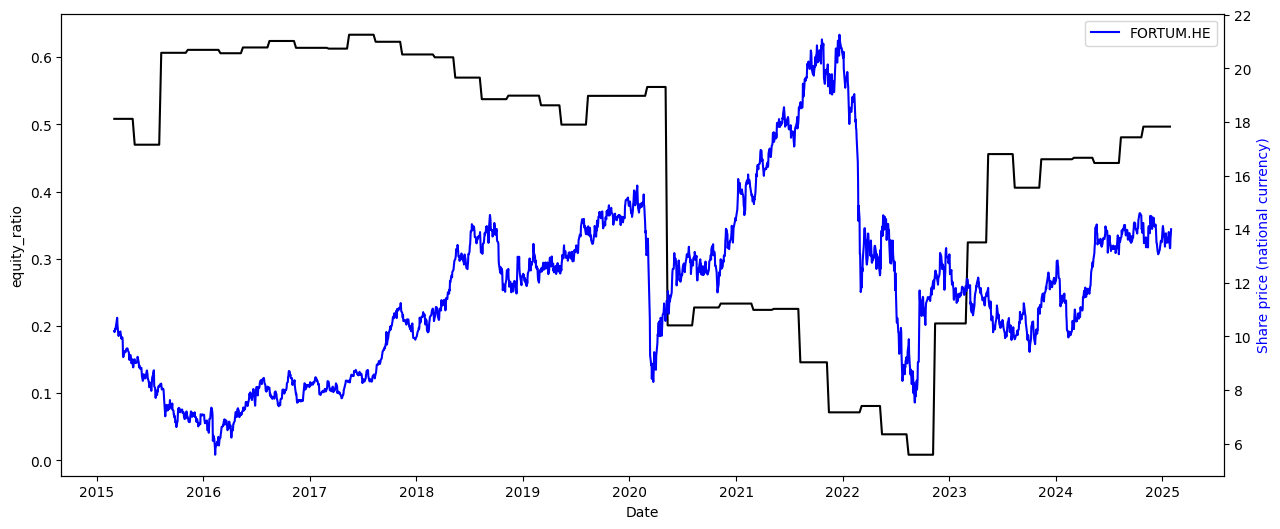

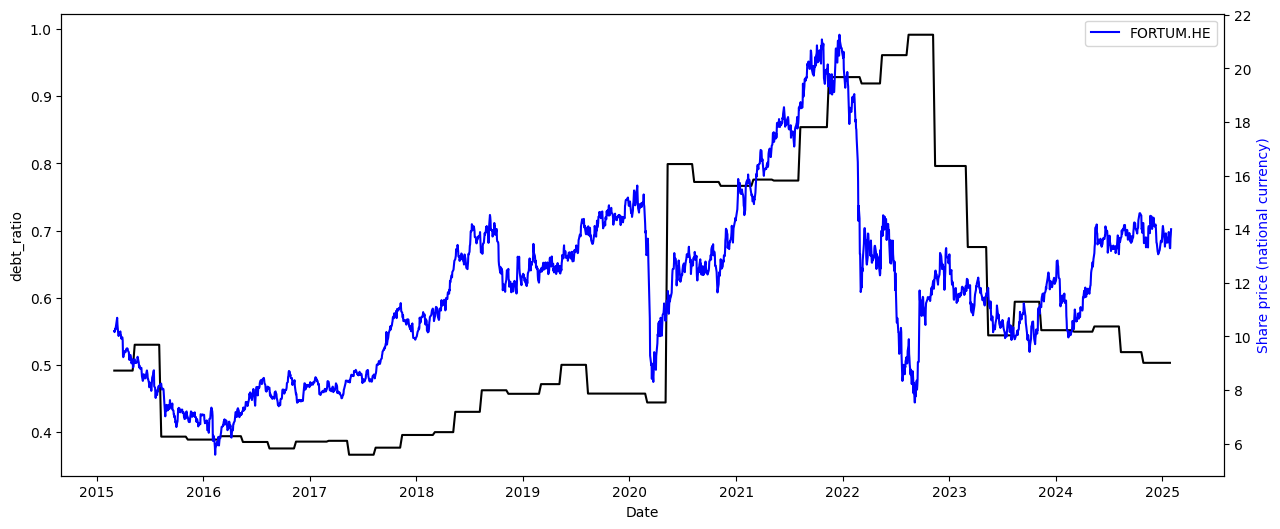

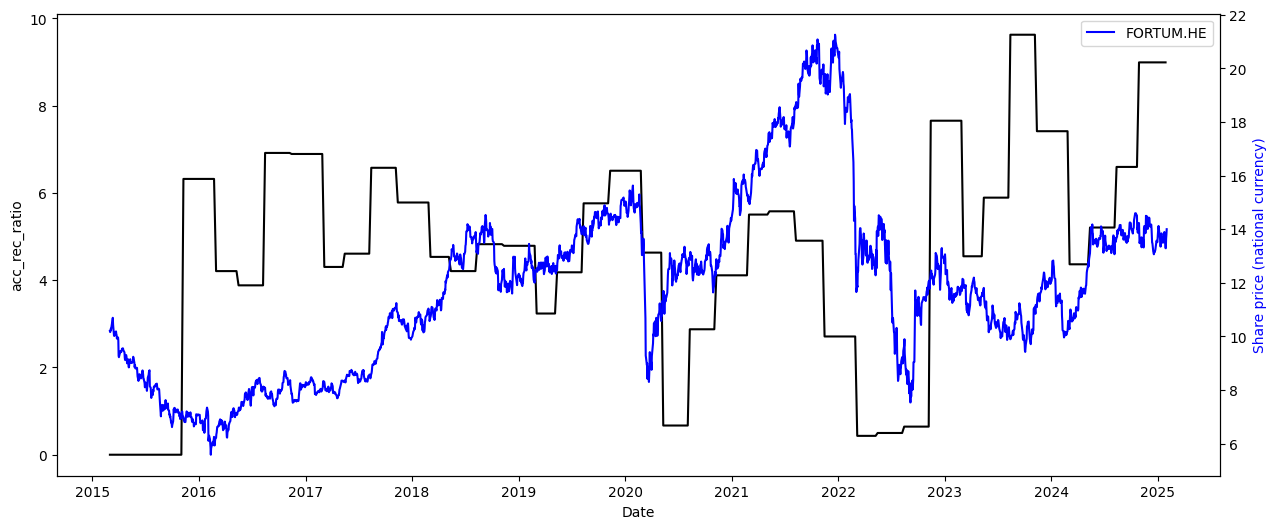

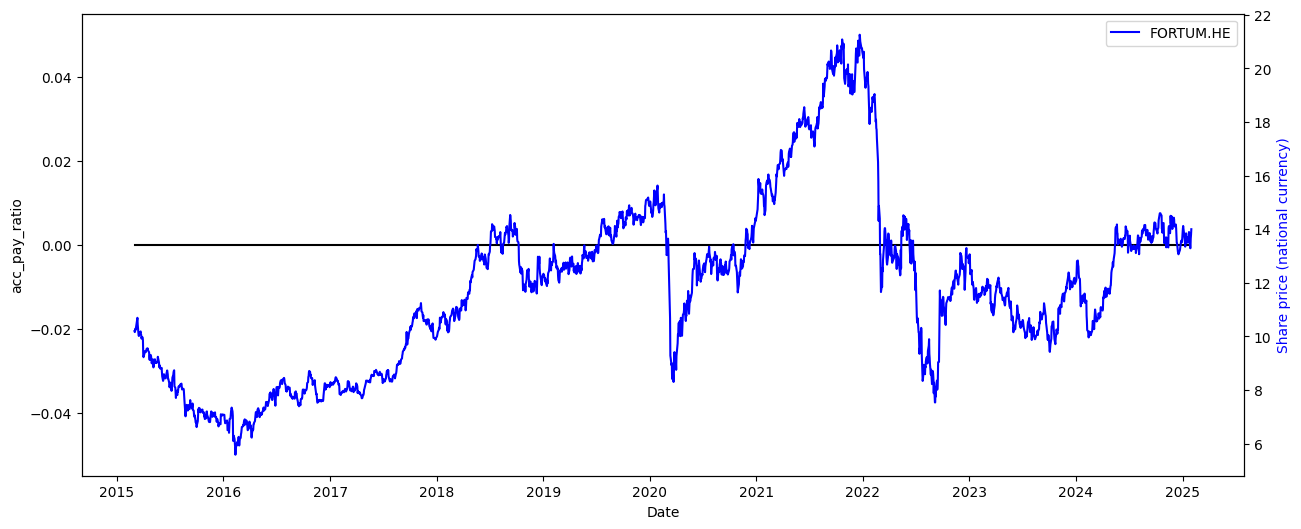

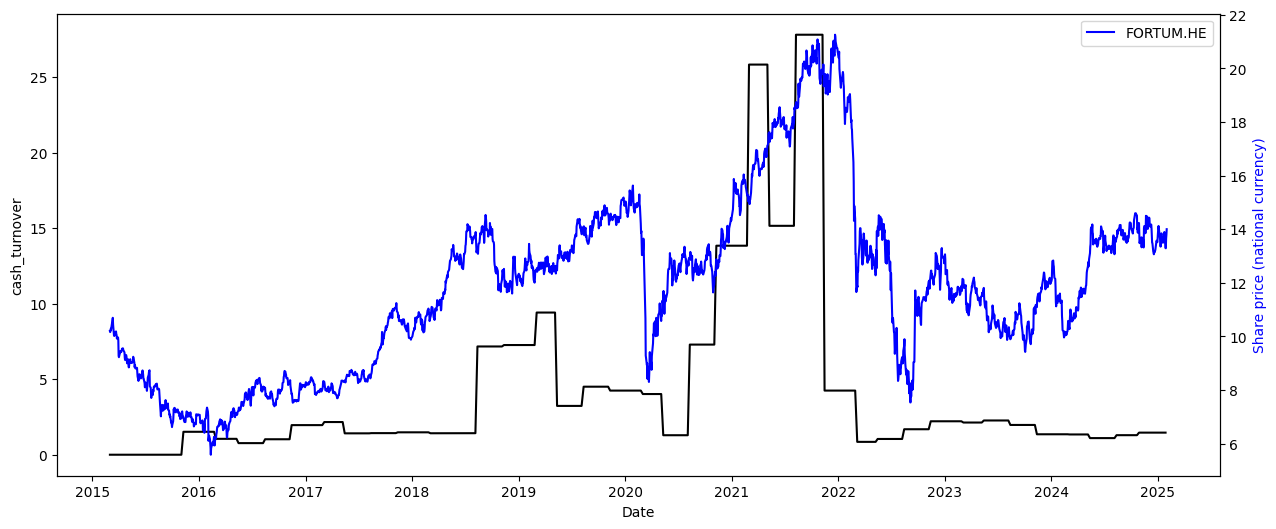

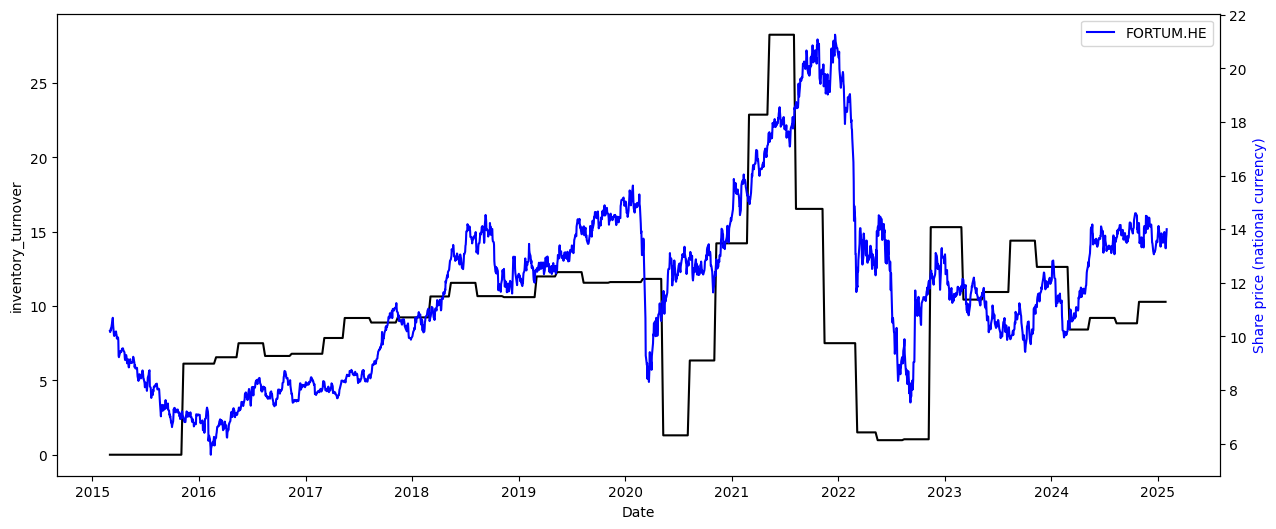

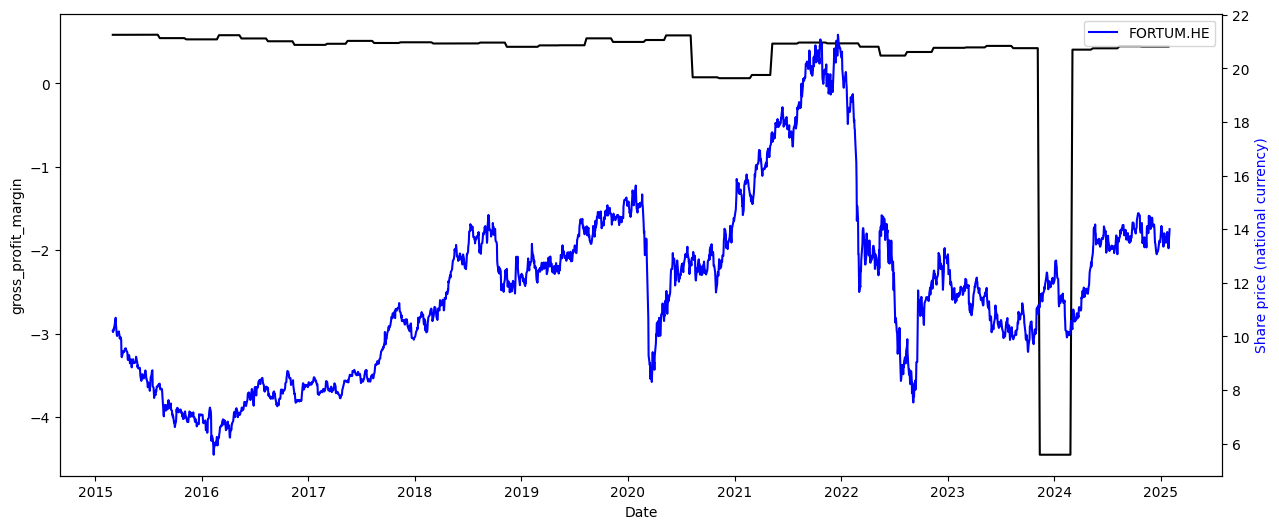

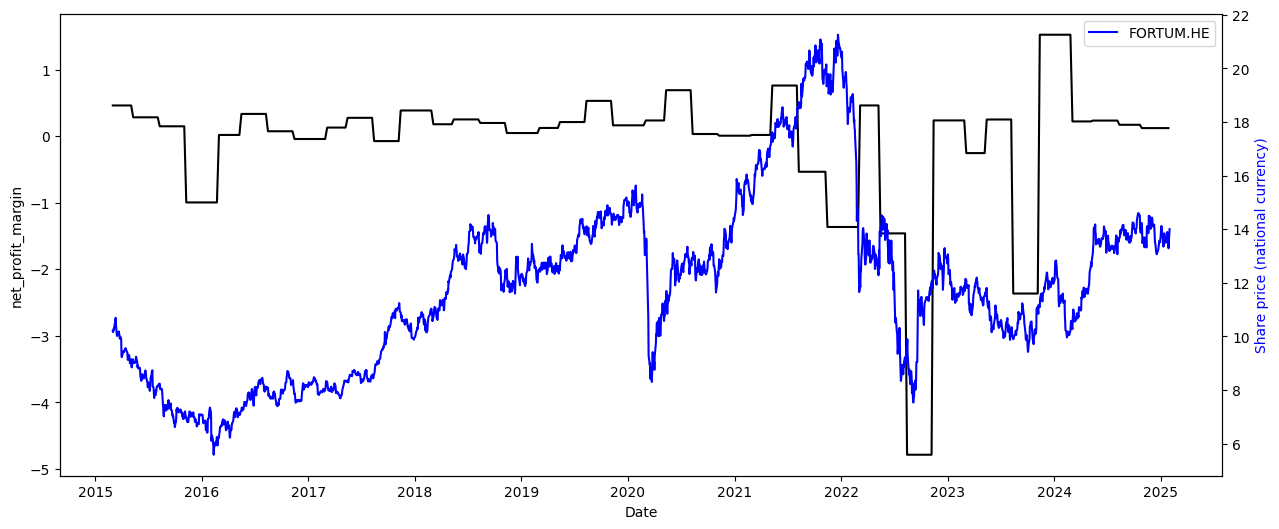

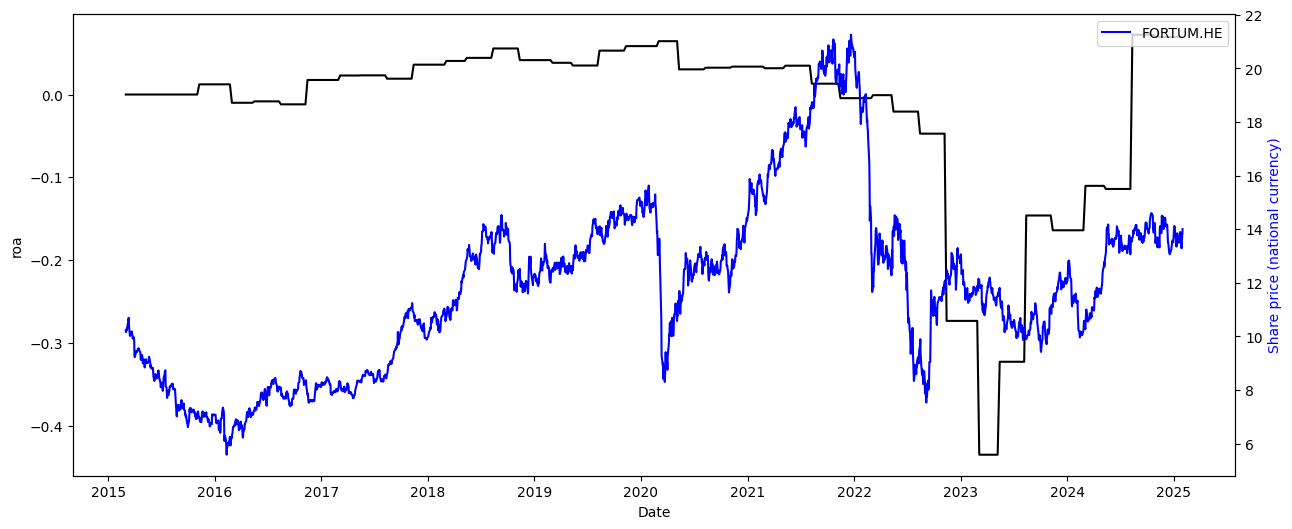

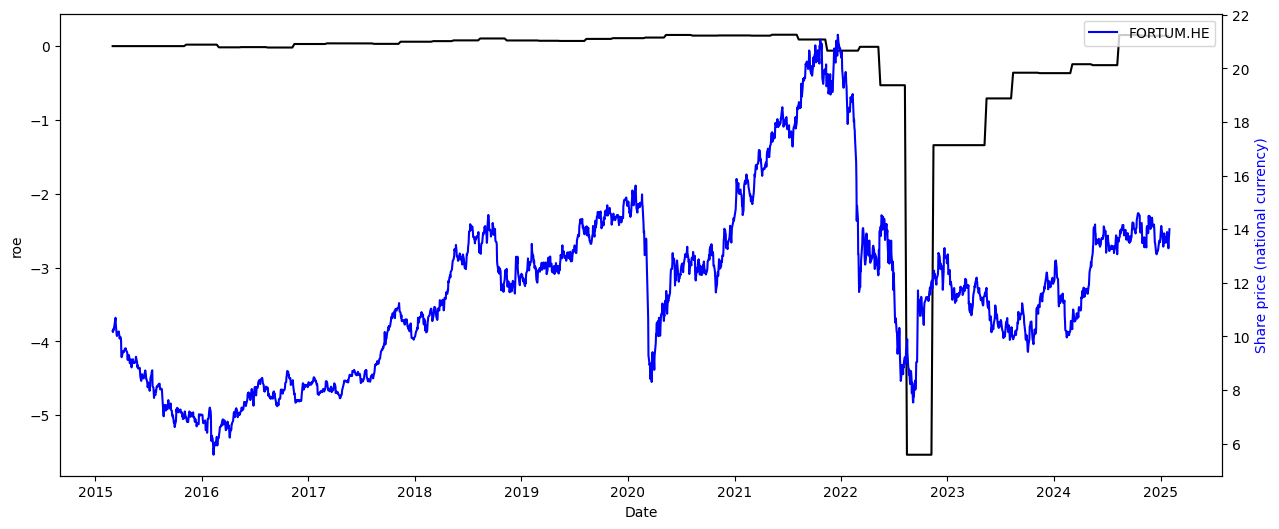

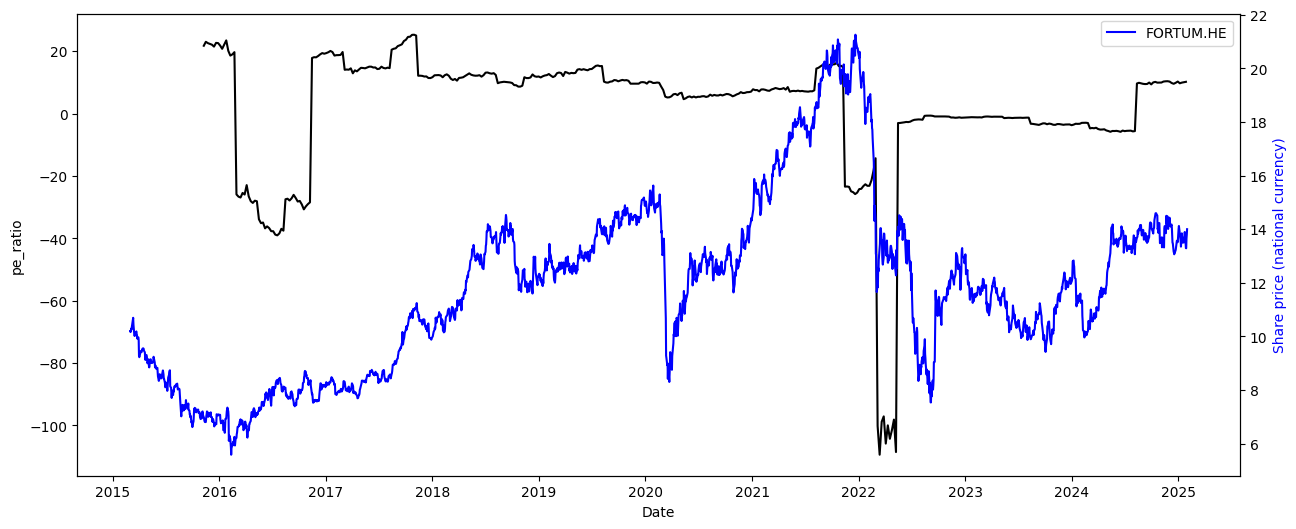

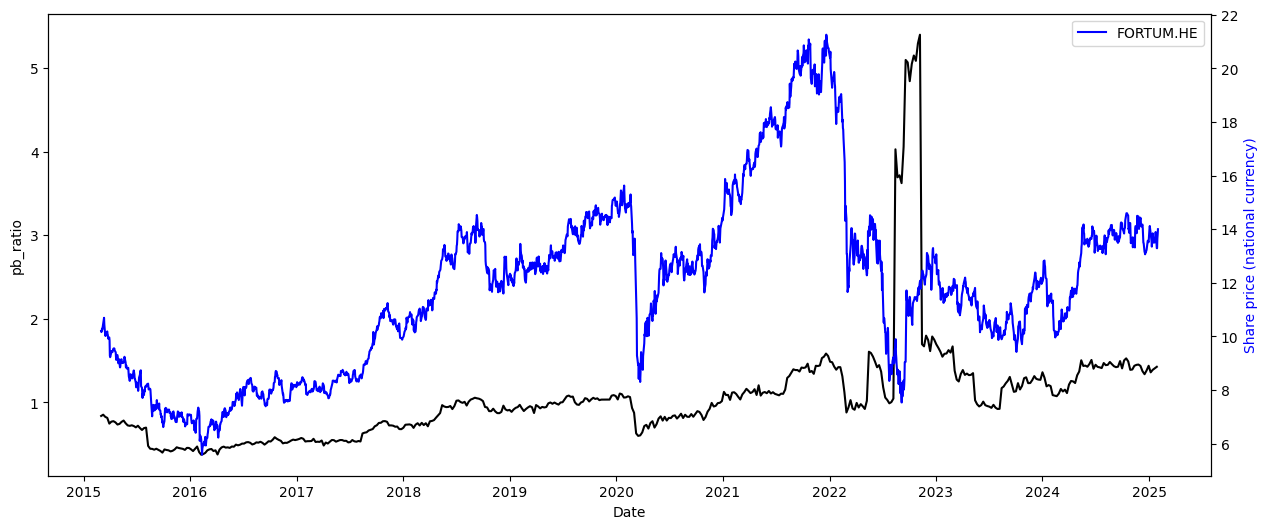

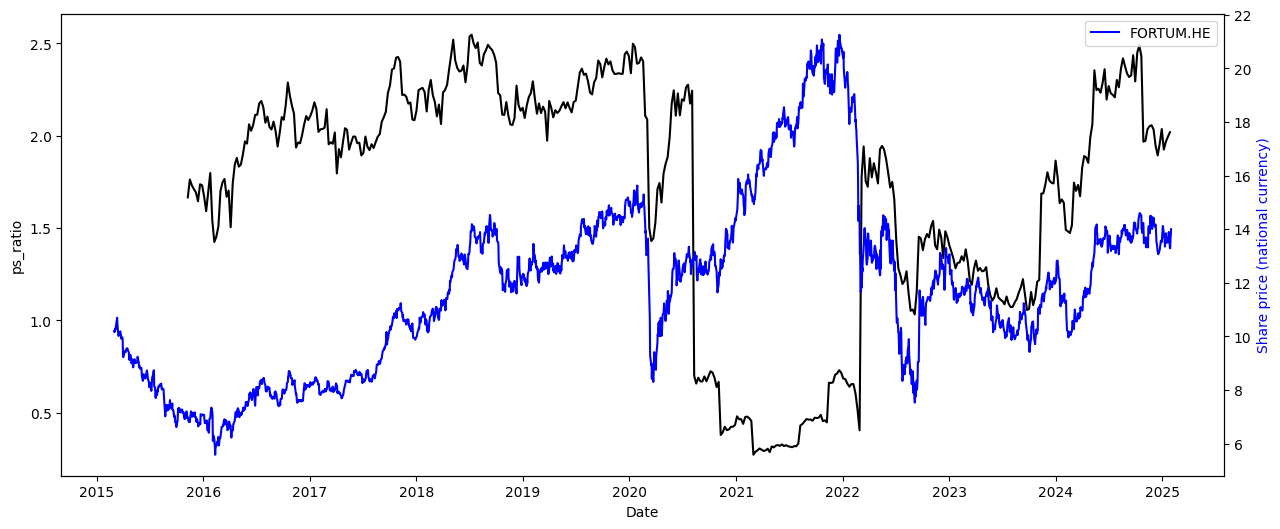

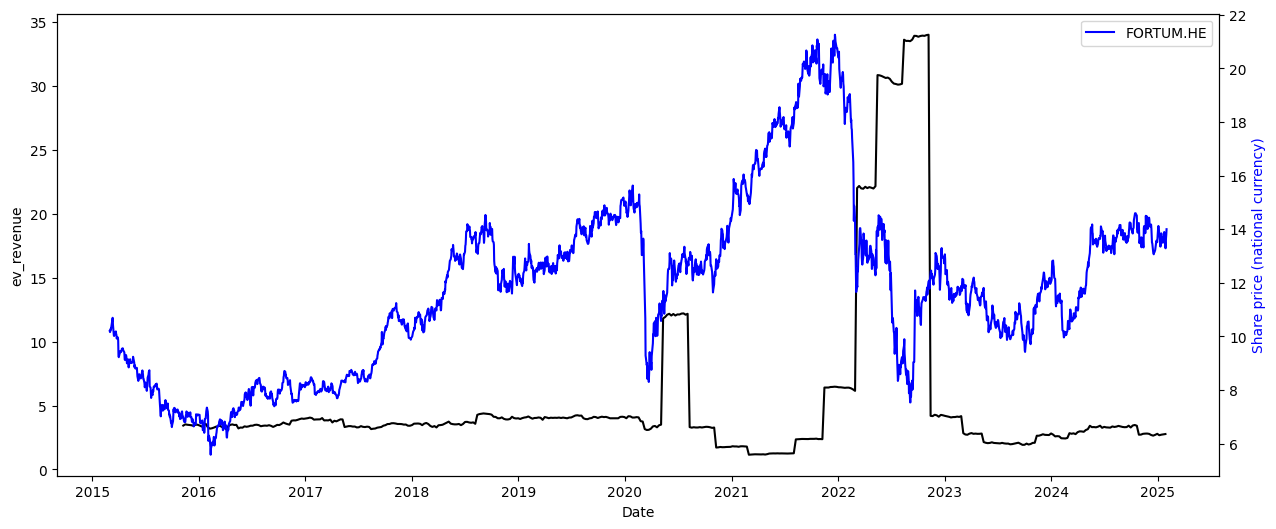

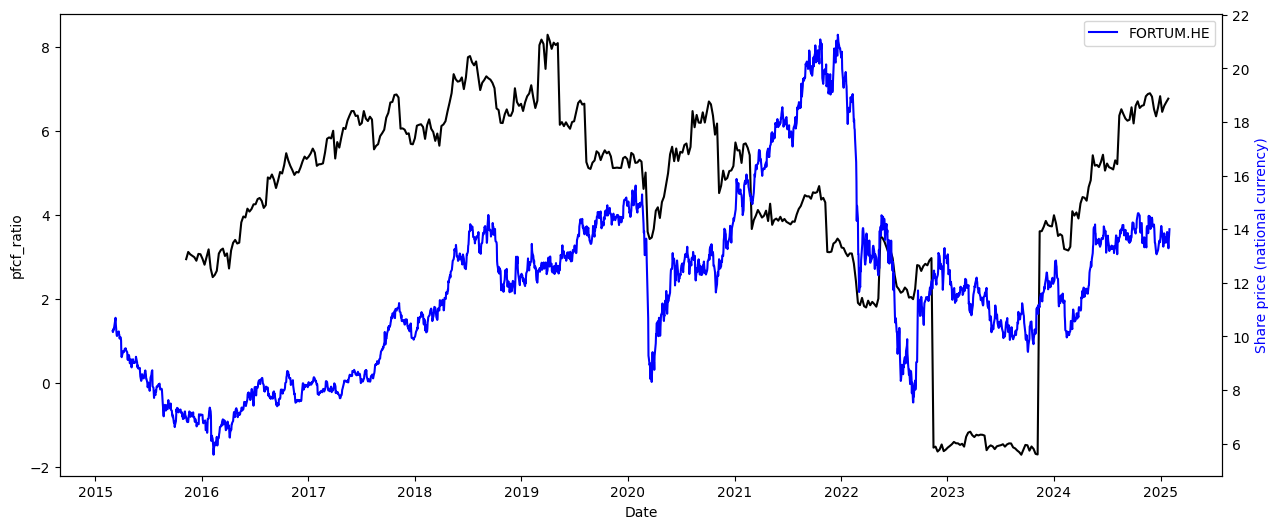

In [18]:
for column in merged_nat_curr.columns[3:]:
    fig, ax1 = plt.subplots(figsize=(15, 6))

    ax2 = ax1.twinx()
    ax1.plot(merged_nat_curr['real_date'], merged_nat_curr[column], color='k', label=merged_nat_curr)
    ax2.plot(ticker_all_price.index, ticker_all_price['Close'], color='b', label=share_name)

    ax1.set_xlabel('Date')
    ax1.set_ylabel(column, color='k')
    ax2.set_ylabel('Share price (national currency)', color='b')

    plt.legend()
    plt.show()

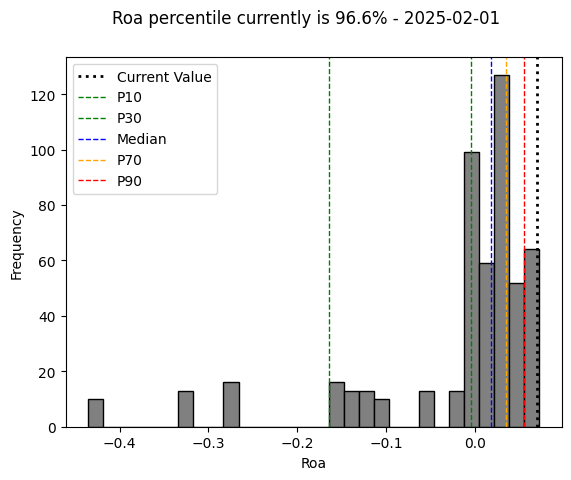

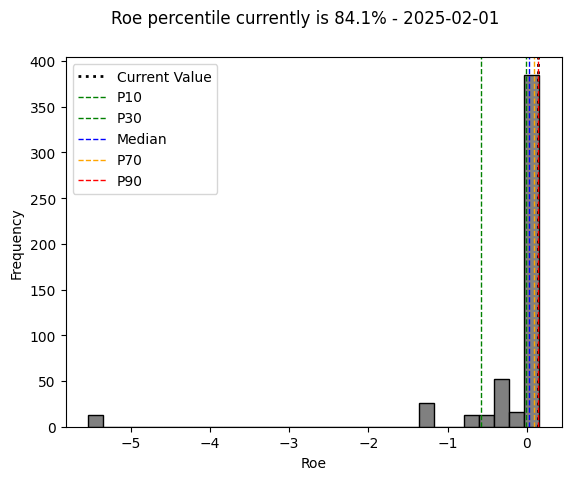

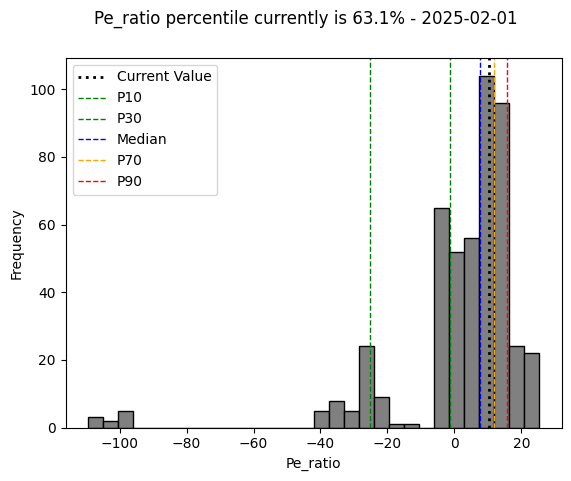

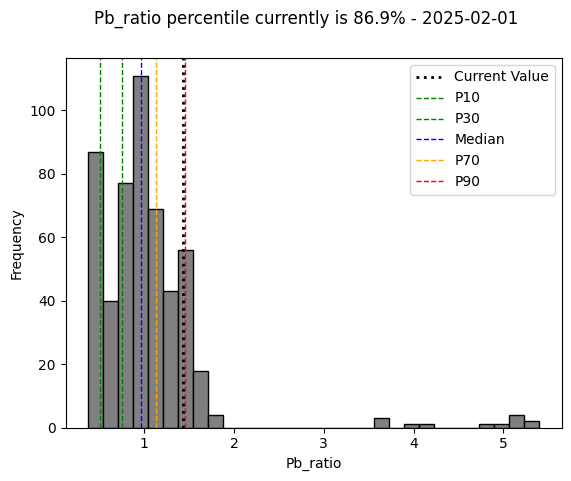

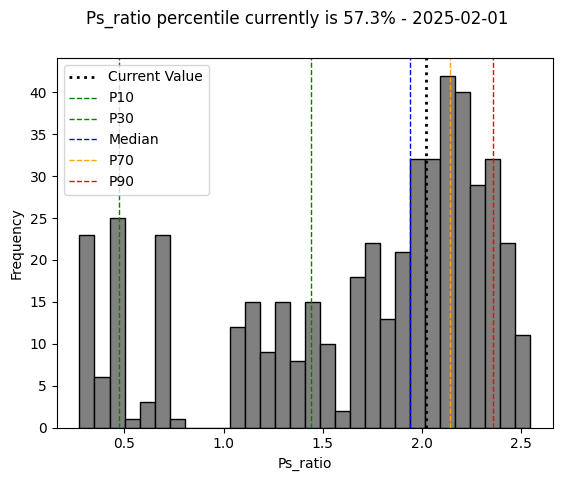

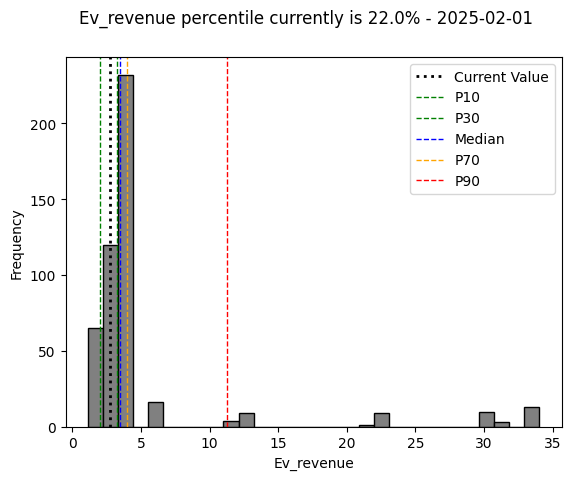

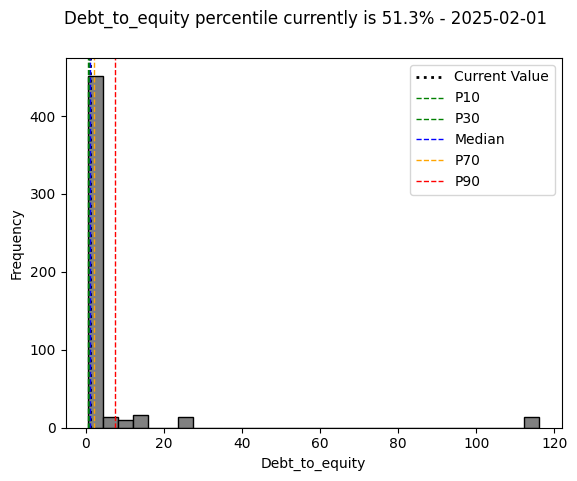

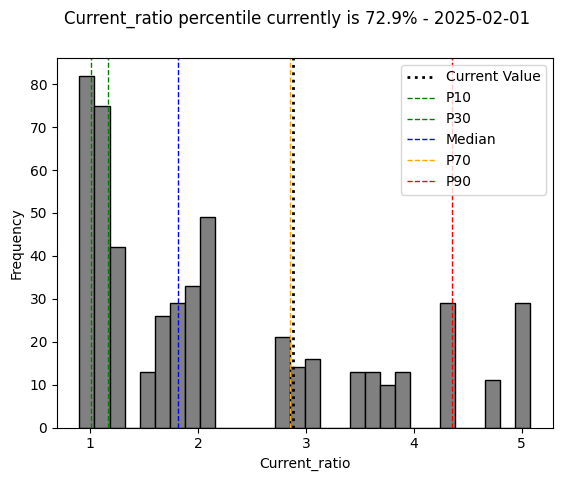

In [19]:
# plot histograms of value parameters
utils.plot_histogram_value_parameters(input_df=merged_nat_curr, extra_parameters=[], owned_shares=owned_shares)

## Calculate correlation between value parameters

In [20]:
# calulate value parameters Pearson's correlation coefficient
pd.DataFrame(merged_nat_curr, columns=['roa', 'roe', 'pe_ratio', 'pb_ratio', 'ps_ratio', 'ev_revenue', 'debt_to_equity', 'current_ratio']).corr()

,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,debt_to_equity,current_ratio
roa,1.000000,0.386456,0.184672,-0.215894,0.233676,0.021418,-0.048363,0.192615
roe,0.386456,1.000000,0.075764,-0.873128,0.146575,-0.648651,-0.917692,0.238919
pe_ratio,0.184672,0.075764,1.000000,-0.035074,0.075398,-0.320286,-0.103221,0.032623
pb_ratio,-0.215894,-0.873128,-0.035074,1.000000,-0.203094,0.606260,0.872259,-0.484323
ps_ratio,0.233676,0.146575,0.075398,-0.203094,1.000000,0.008799,-0.173778,0.352231
ev_revenue,0.021418,-0.648651,-0.320286,0.606260,0.008799,1.000000,0.795109,-0.289634
debt_to_equity,-0.048363,-0.917692,-0.103221,0.872259,-0.173778,0.795109,1.000000,-0.260082
current_ratio,0.192615,0.238919,0.032623,-0.484323,0.352231,-0.289634,-0.260082,1.000000


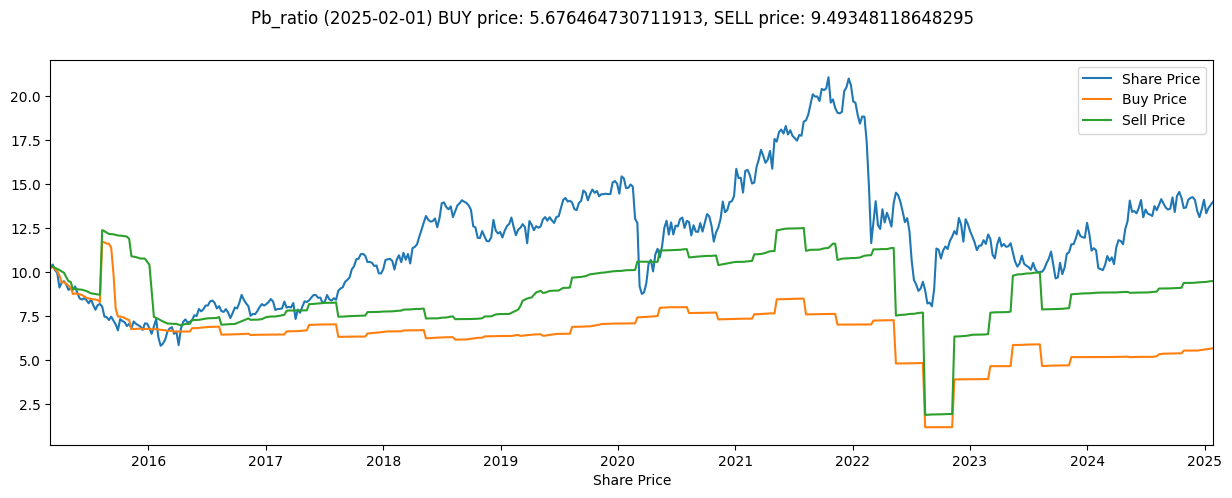

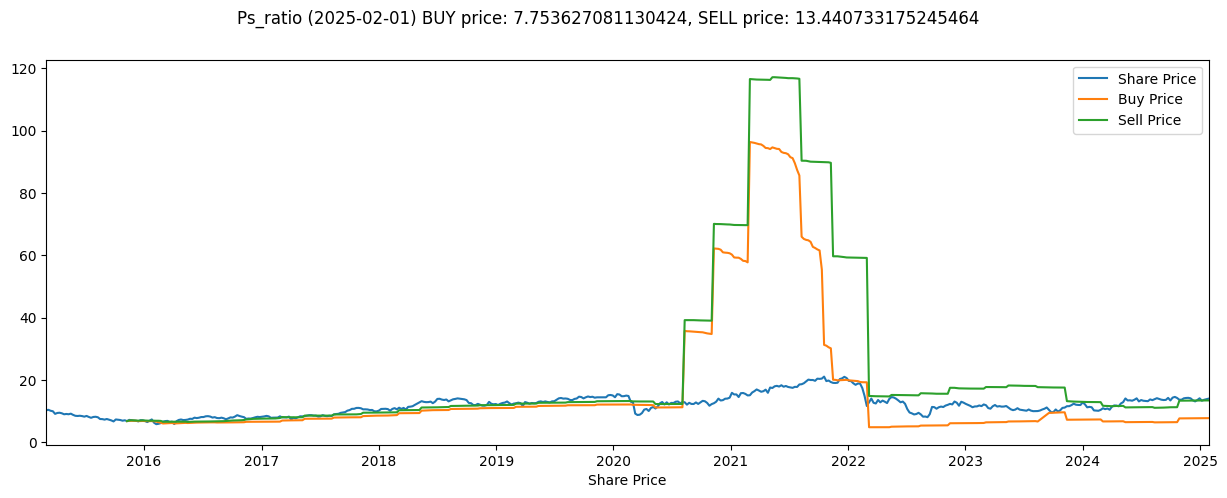

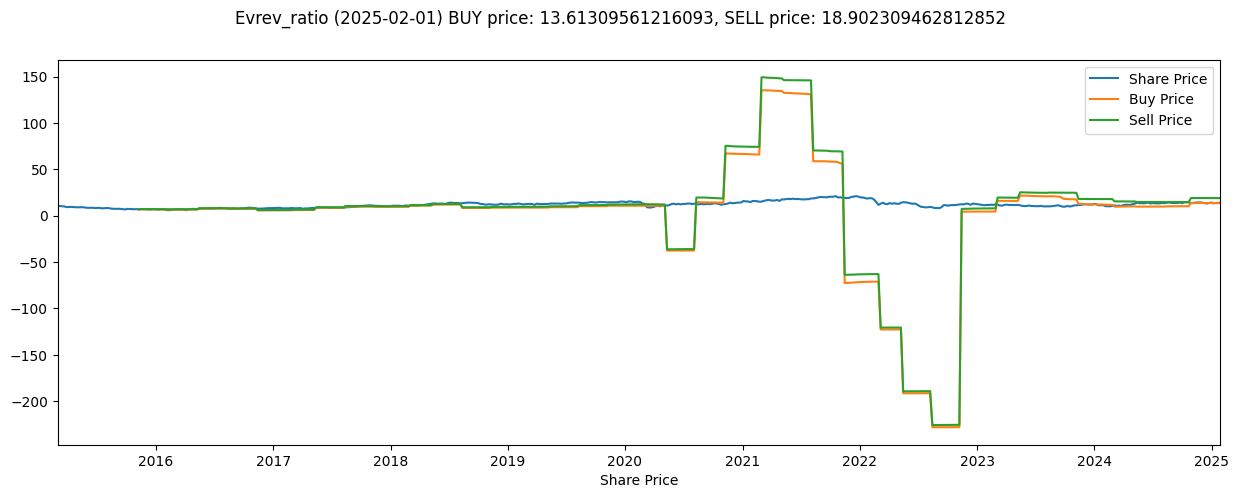

In [21]:
final_df = utils.get_value_stock_target_prices(
    input_df=merged_nat_curr,
    min_pct=0.2,
    max_pct=0.5,
    owned_shares=owned_shares
)